### Imports

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import loguniform, randint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

### Data preparation and visualisation

In [10]:
data = pd.read_csv("features.csv")
data.head()

,url,label,url_length,number_of_slashes,is_https,number_of_http_occurrences,number_of_https_occurrences,number_of_dots,is_ip,number_of_digits,...,ratio_of_special_chars,number_of_subdirectories,number_of_query_params,tld_length,has_fragment_identifier,has_credentials,is_known_shortening_service,domain_length,char_continuation_rate,suspicious_keywords
0,http://4aoo-bmmanager045288.vercel.app/?naps,0,44,3,0,1,0,2,0,7,...,0.181818,0,1,3,0,0,0,31,0.409091,0
1,http://0suz-bmmanager047181.vercel.app/?naps,0,44,3,0,1,0,2,0,7,...,0.181818,0,1,3,0,0,0,31,0.409091,0
2,http://ncrm-casefb588197.vercel.app/?naps,0,41,3,0,1,0,2,0,6,...,0.195122,0,1,3,0,0,0,28,0.365854,0
3,http://casefb668303-f2w6.vercel.app/?naps,0,41,3,0,1,0,2,0,8,...,0.195122,0,1,3,0,0,0,28,0.365854,0
4,http://casefb480777-qhn9.vercel.app/?naps,0,41,3,0,1,0,2,0,7,...,0.195122,0,1,3,0,0,0,28,0.365854,0


In [11]:
data.columns

Index(['url', 'label', 'url_length', 'number_of_slashes', 'is_https',
       'number_of_http_occurrences', 'number_of_https_occurrences',
       'number_of_dots', 'is_ip', 'number_of_digits', 'number_of_dashes',
       'has_at_symbol', 'number_of_double_slashes', 'number_of_subdomains',
       'number_of_dashes_in_domain', 'contains_query', 'ratio_of_digits',
       'rare_top_level_domain', 'number_of_special_chars',
       'ratio_of_special_chars', 'number_of_subdirectories',
       'number_of_query_params', 'tld_length', 'has_fragment_identifier',
       'has_credentials', 'is_known_shortening_service', 'domain_length',
       'char_continuation_rate', 'suspicious_keywords'],
      dtype='object')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21462 entries, 0 to 21461
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   url                          21462 non-null  object 
 1   label                        21462 non-null  int64  
 2   url_length                   21462 non-null  int64  
 3   number_of_slashes            21462 non-null  int64  
 4   is_https                     21462 non-null  int64  
 5   number_of_http_occurrences   21462 non-null  int64  
 6   number_of_https_occurrences  21462 non-null  int64  
 7   number_of_dots               21462 non-null  int64  
 8   is_ip                        21462 non-null  int64  
 9   number_of_digits             21462 non-null  int64  
 10  number_of_dashes             21462 non-null  int64  
 11  has_at_symbol                21462 non-null  int64  
 12  number_of_double_slashes     21462 non-null  int64  
 13  number_of_subdom

In [13]:
data.nunique()

url                            16734
label                              2
url_length                       242
number_of_slashes                 14
is_https                           2
number_of_http_occurrences         2
number_of_https_occurrences        3
number_of_dots                    29
is_ip                              1
number_of_digits                  91
number_of_dashes                  33
has_at_symbol                      2
number_of_double_slashes           2
number_of_subdomains              23
number_of_dashes_in_domain         9
contains_query                     2
ratio_of_digits                 1265
rare_top_level_domain              1
number_of_special_chars           57
ratio_of_special_chars           866
number_of_subdirectories          13
number_of_query_params            15
tld_length                        14
has_fragment_identifier            2
has_credentials                    2
is_known_shortening_service        2
domain_length                     95
c

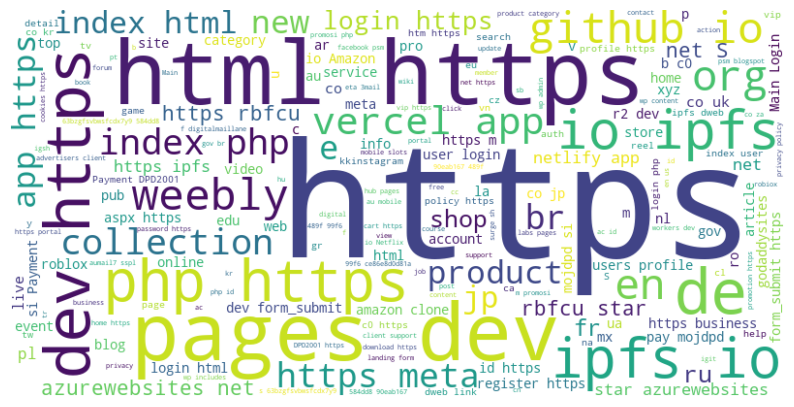

In [15]:
from wordcloud import WordCloud

# combine all rows into a single string
urls = " ".join(data['url'])

word_cloud = WordCloud(width=800,height=400,background_color='white').generate(urls)

plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [7]:
data = data.drop(['url'], axis=1)

In [263]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
label,21462.0,0.629857,0.482854,0.000000,0.00000,1.000000,1.000000,1.000000
url_length,21462.0,52.830072,35.348433,13.000000,34.00000,45.000000,62.000000,1404.000000
number_of_slashes,21462.0,3.898844,1.123919,3.000000,3.00000,4.000000,4.000000,24.000000
is_https,21462.0,0.765912,0.423437,0.000000,1.00000,1.000000,1.000000,1.000000
number_of_http_occurrences,21462.0,0.234181,0.423496,0.000000,0.00000,0.000000,0.000000,1.000000
number_of_https_occurrences,21462.0,0.766518,0.424486,0.000000,1.00000,1.000000,1.000000,2.000000
number_of_dots,21462.0,2.107073,2.056469,1.000000,1.00000,2.000000,3.000000,168.000000
is_ip,21462.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
number_of_digits,21462.0,3.240705,8.062765,0.000000,0.00000,0.000000,4.000000,277.000000
number_of_dashes,21462.0,1.587131,2.937402,0.000000,0.00000,1.000000,2.000000,34.000000


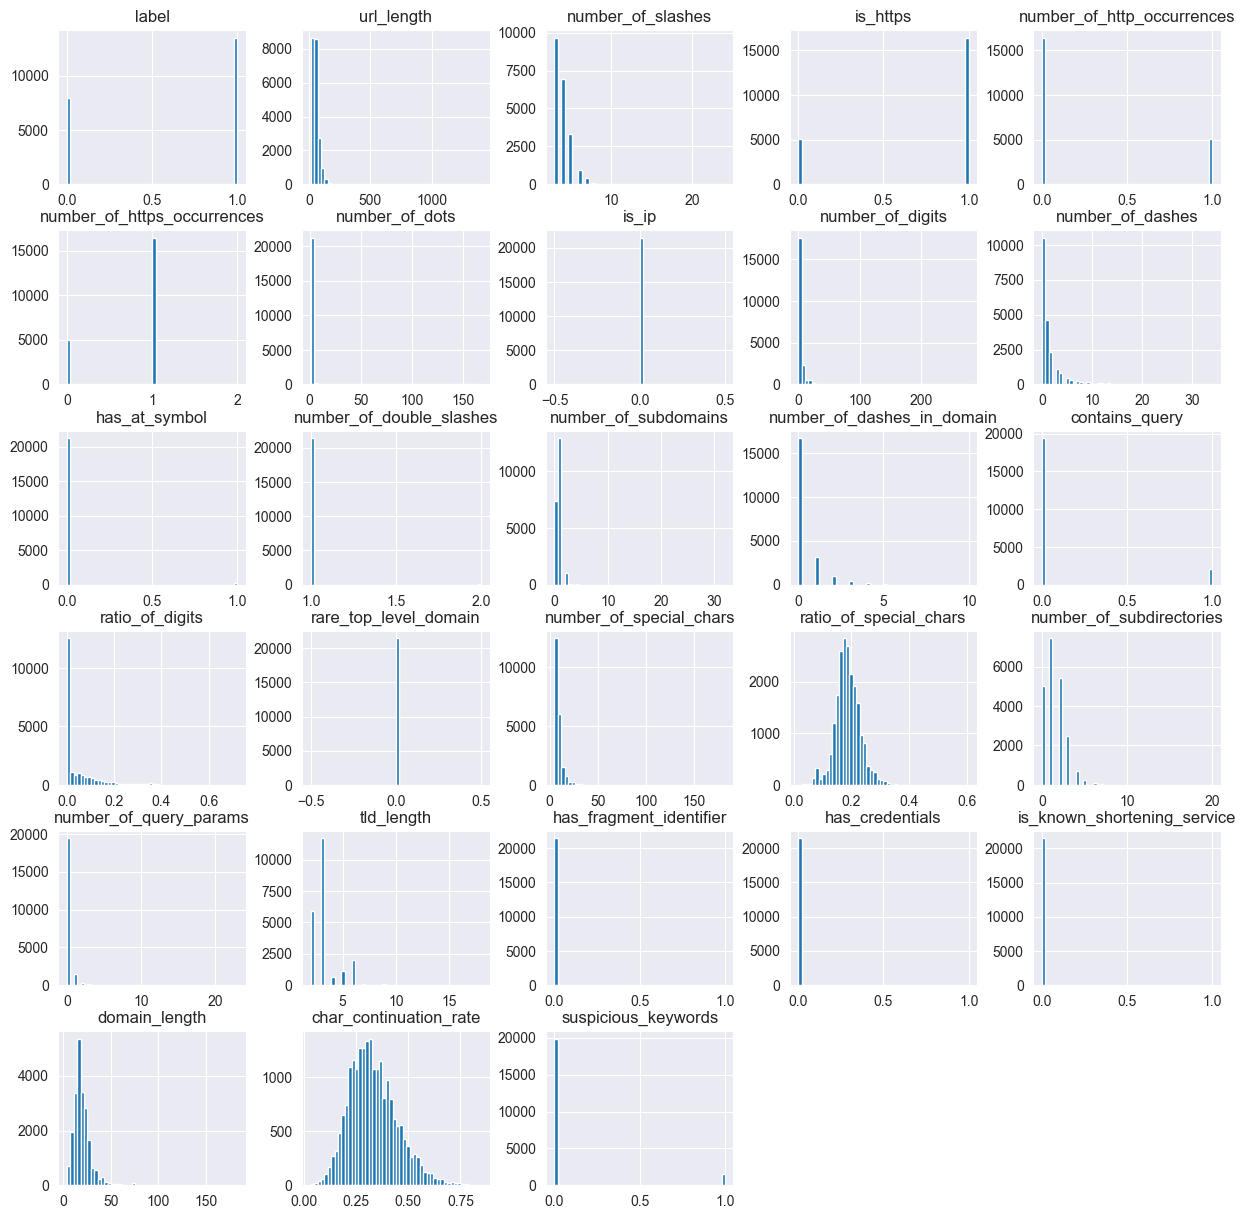

In [264]:
data.hist(bins=50, figsize=(15, 15))
plt.show()

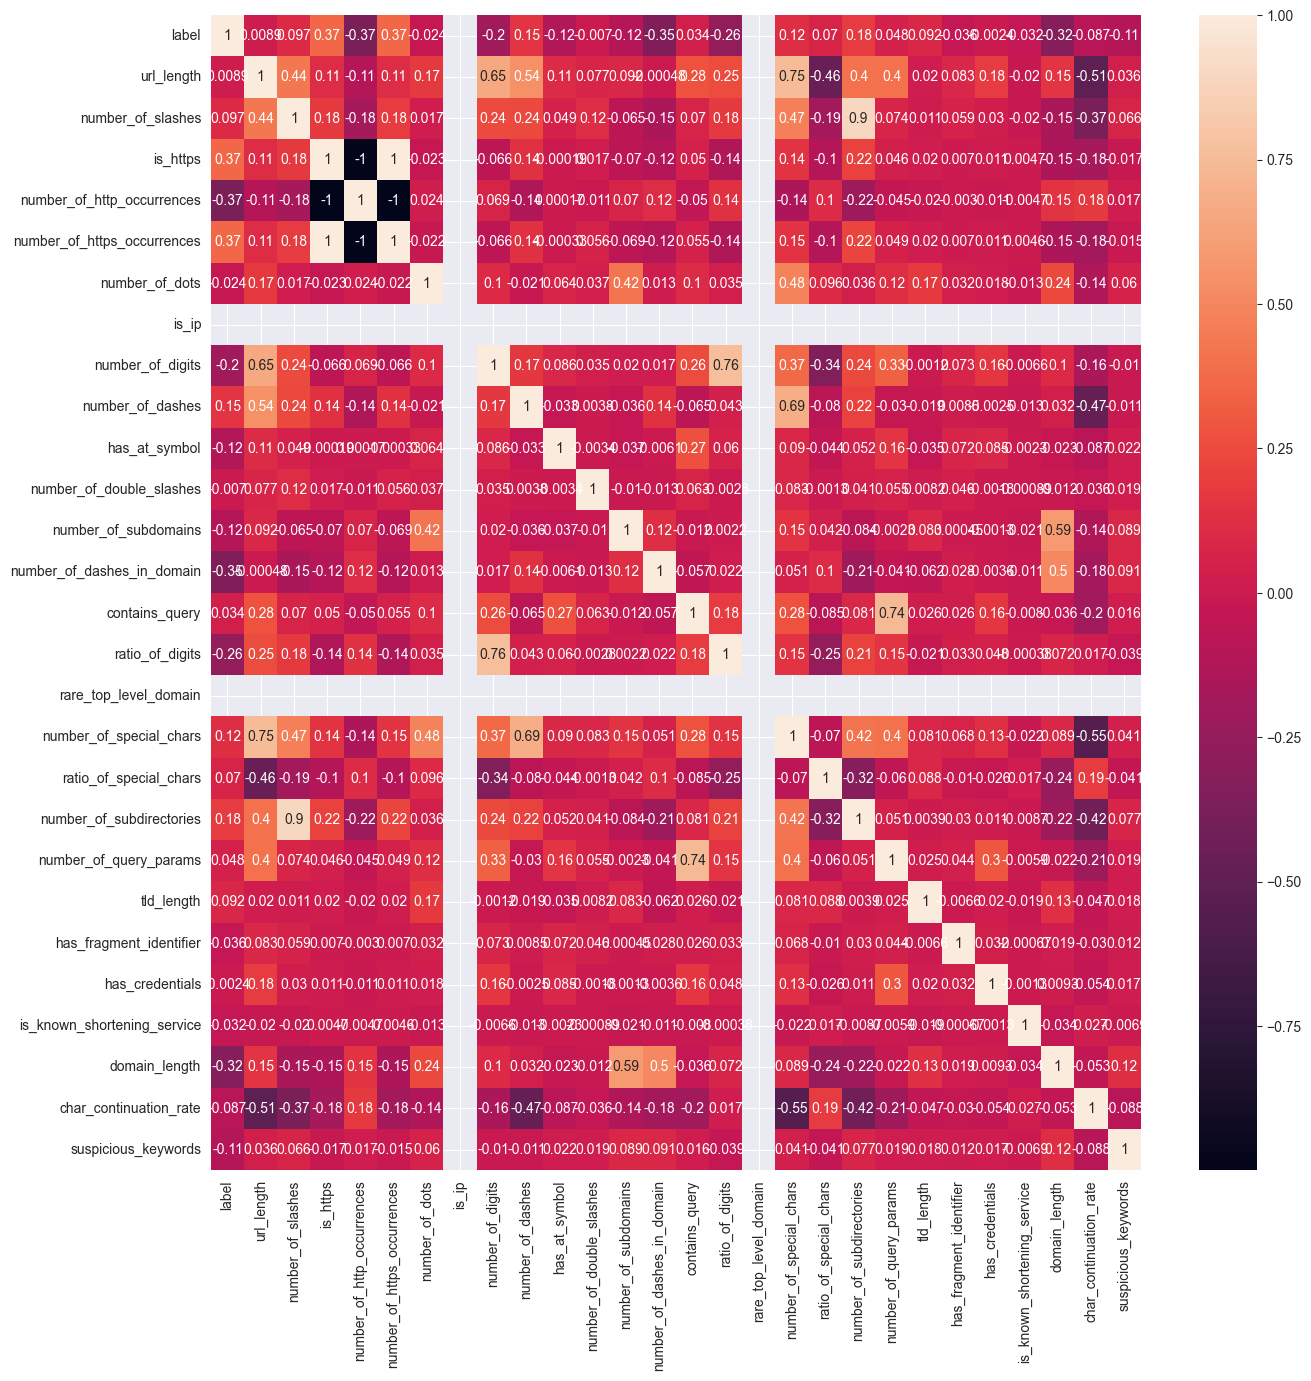

In [265]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(), annot=True)
plt.show()

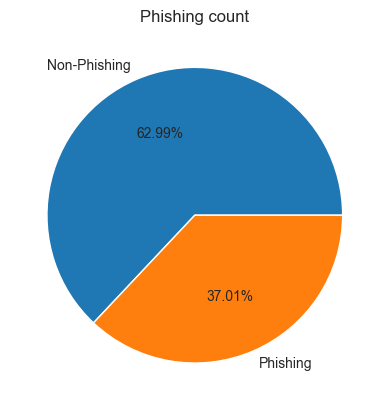

In [279]:
counts = data['label'].value_counts()
counts = counts.rename(index={0: 'Phishing', 1: 'Non-Phishing'})
counts.plot(kind='pie', autopct='%1.2f%%')
plt.title("Phishing count")
plt.ylabel('')
plt.show()

In [293]:
X = data.drop(['label'], axis=1)
y = data['label']

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17169, 27), (4293, 27), (17169,), (4293,))

### Support Vector Machine

In [295]:
pipe = Pipeline([("scaler", StandardScaler()), ("svc", SVC())])

In [296]:
param_dist = {
  "svc__kernel": ["rbf"], # rbf kernel, weil am stärksten
  "svc__C": loguniform(1e-2, 1e2), # Hohes C → Versucht alle Punkte richtig zu klassifizieren: 0.01..100
  "svc__gamma": loguniform(1e-4, 1e-1), # Hohes Gamma --> Starke Anpassung an Trainingsdaten 0.0001 bis 0.1
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs = RandomizedSearchCV(pipe, param_dist, cv=cv, scoring="f1", n_jobs=-1, n_iter=36)

rs.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc', SVC())]),
                   n_iter=36, n_jobs=-1,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x134327460>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x133859d60>,
                                        'svc__kernel': ['rbf']},
                   scoring='f1')

In [297]:
y_train_svc = rs.predict(X_train)
y_test_svc = rs.predict(X_test)

# safe best model:
best_model_svc = rs.best_estimator_
print(rs.best_params_)

{'svc__C': np.float64(43.27889165254429), 'svc__gamma': np.float64(0.027974842130560885), 'svc__kernel': 'rbf'}


In [298]:
acc_train_svc = metrics.accuracy_score(y_train,y_train_svc)
acc_test_svc = metrics.accuracy_score(y_test,y_test_svc)
print("Support Vector Machine : Accuracy on training Data: {:.3f}".format(acc_train_svc))
print("Support Vector Machine : Accuracy on test Data: {:.3f}".format(acc_test_svc))
print()

f1_score_train_svc = metrics.f1_score(y_train,y_train_svc)
f1_score_test_svc = metrics.f1_score(y_test,y_test_svc)
print("Support Vector Machine : f1_score on training Data: {:.3f}".format(f1_score_train_svc))
print("Support Vector Machine : f1_score on test Data: {:.3f}".format(f1_score_test_svc))
print()

recall_score_train_svc = metrics.recall_score(y_train,y_train_svc)
recall_score_test_svc = metrics.recall_score(y_test,y_test_svc)
print("Support Vector Machine : Recall on training Data: {:.3f}".format(recall_score_train_svc))
print("Support Vector Machine : Recall on test Data: {:.3f}".format(recall_score_test_svc))
print()

precision_score_train_svc = metrics.precision_score(y_train,y_train_svc)
precision_score_test_svc = metrics.precision_score(y_test,y_test_svc)
print("Support Vector Machine : precision on training Data: {:.3f}".format(precision_score_train_svc))
print("Support Vector Machine : precision on test Data: {:.3f}".format(precision_score_test_svc))

Support Vector Machine : Accuracy on training Data: 0.909
Support Vector Machine : Accuracy on test Data: 0.894

Support Vector Machine : f1_score on training Data: 0.930
Support Vector Machine : f1_score on test Data: 0.918

Support Vector Machine : Recall on training Data: 0.948
Support Vector Machine : Recall on test Data: 0.940

Support Vector Machine : precision on training Data: 0.912
Support Vector Machine : precision on test Data: 0.897


In [300]:
print(metrics.classification_report(y_test, y_test_svc))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1589
           1       0.90      0.94      0.92      2704

    accuracy                           0.89      4293
   macro avg       0.89      0.88      0.88      4293
weighted avg       0.89      0.89      0.89      4293



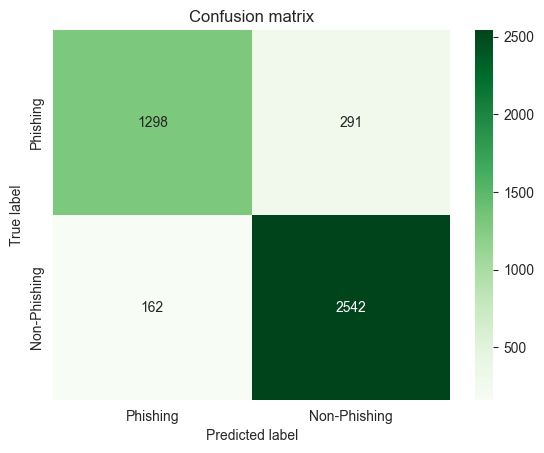

In [301]:
svm_conf_matrix = metrics.confusion_matrix(y_test, y_test_svc)
labels = ['Phishing', 'Non-Phishing']

sns.heatmap(svm_conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

### Random Forest

In [395]:
param_dist = {
    "criterion": ["gini"], # nur gini, wel entropy kaum unterschied macht und gini schneller ist
    "n_estimators": randint(200, 601), # Anzahl der Bäume: 200..600
    "max_depth": [None, 4, 8, 16, 32], # Baumtiefe, zu tiefe Bäume = Overfitting
    "min_samples_leaf": randint(1, 10), # Minimale Anzahl an Blättern 1..9
    "min_samples_split": randint(2, 21), # Minimale Anzahl an Splits 2..20
    "max_features": ['sqrt', 0.4, 0.6, 0.8], # Feature-Sampling pro Split
}

param_dist_paper = {
    "criterion": ["gini"], # nur gini, wel entropy kaum unterschied macht und gini schneller ist
    "n_estimators": [10], # Anzahl der Bäume: 200..600
    "max_depth": [8], # Baumtiefe, zu tiefe Bäume = Overfitting
    "max_features": ['sqrt'], # Feature-Sampling pro Split
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=42),
    param_distributions=param_dist, n_iter=36, cv=cv,
    scoring="f1", n_jobs=-1, random_state=42
)
rs.fit(X_train, y_train)
best_rf = rs.best_estimator_
print(best_rf)
rs.best_params_

RandomForestClassifier(max_depth=32, max_features=0.6, min_samples_split=8,
                       n_estimators=208, n_jobs=-1, random_state=42)


{'criterion': 'gini',
 'max_depth': 32,
 'max_features': 0.6,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 208}

In [396]:
#predicting the target value from the model for the samples
y_train_forest = rs.predict(X_train)
y_test_forest = rs.predict(X_test)

In [397]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_forest = metrics.accuracy_score(y_train,y_train_forest)
acc_test_forest = metrics.accuracy_score(y_test,y_test_forest)
print("Random Forest : Accuracy on training Data: {:.3f}".format(acc_train_forest))
print("Random Forest : Accuracy on test Data: {:.3f}".format(acc_test_forest))
print()

f1_score_train_forest = metrics.f1_score(y_train,y_train_forest)
f1_score_test_forest = metrics.f1_score(y_test,y_test_forest)
print("Random Forest : f1_score on training Data: {:.3f}".format(f1_score_train_forest))
print("Random Forest : f1_score on test Data: {:.3f}".format(f1_score_test_forest))
print()

recall_score_train_forest = metrics.recall_score(y_train,y_train_forest)
recall_score_test_forest = metrics.recall_score(y_test,y_test_forest)
print("Random Forest : Recall on training Data: {:.3f}".format(recall_score_train_forest))
print("Random Forest : Recall on test Data: {:.3f}".format(recall_score_test_forest))
print()

precision_score_train_forest = metrics.precision_score(y_train,y_train_forest)
precision_score_test_forest = metrics.precision_score(y_test,y_test_forest)
print("Random Forest : precision on training Data: {:.3f}".format(precision_score_train_forest))
print("Random Forest : precision on test Data: {:.3f}".format(precision_score_test_forest))

Random Forest : Accuracy on training Data: 0.966
Random Forest : Accuracy on test Data: 0.908

Random Forest : f1_score on training Data: 0.974
Random Forest : f1_score on test Data: 0.929

Random Forest : Recall on training Data: 0.983
Random Forest : Recall on test Data: 0.949

Random Forest : precision on training Data: 0.965
Random Forest : precision on test Data: 0.910


In [398]:
print(metrics.classification_report(y_test, y_test_forest))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1589
           1       0.91      0.95      0.93      2704

    accuracy                           0.91      4293
   macro avg       0.91      0.89      0.90      4293
weighted avg       0.91      0.91      0.91      4293



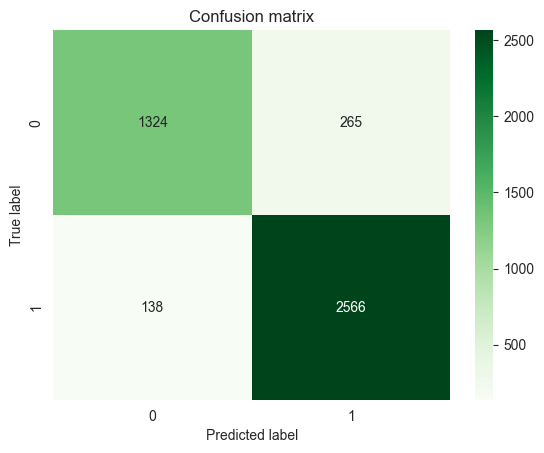

In [373]:
forest_conf_matrix = metrics.confusion_matrix(y_test, y_test_forest)

sns.heatmap(forest_conf_matrix, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

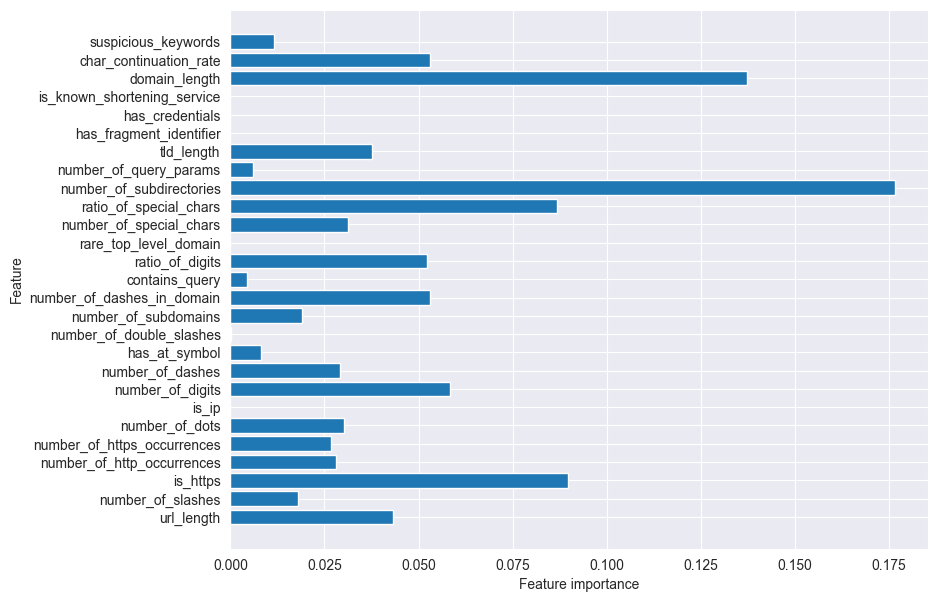

In [285]:
#checking the feature improtance in the model
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), best_rf.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

### Decision Tree

In [403]:
param_dist = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None, 4, 8, 16, 20, 32],
    "min_samples_leaf": randint(1, 5),
    "min_samples_split": randint(2, 10),
    "max_features": [None, 'sqrt', 0.4, 0.6, 0.8],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42),
                        param_dist, n_iter=36, cv=cv, scoring="f1", n_jobs=-1,
                        random_state=42)
rs.fit(X_train, y_train)
best_tree = rs.best_estimator_
rs.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 0.8,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

In [404]:
#predicting the target value from the model for the samples
y_test_tree = rs.predict(X_test)
y_train_tree = rs.predict(X_train)

In [409]:
#computing the accuracy of the model performance
acc_train_tree = accuracy_score(y_train,y_train_tree)
acc_test_tree = accuracy_score(y_test,y_test_tree)

print("Decision Tree: Accuracy on training Data: {:.3f}".format(acc_train_tree))
print("Decision Tree: Accuracy on test Data: {:.3f}".format(acc_test_tree))
print()

f1_score_train_tree = metrics.f1_score(y_train,y_train_tree)
f1_score_test_tree = metrics.f1_score(y_test,y_test_tree)
print("Decision Tree: f1_score on training Data: {:.3f}".format(f1_score_train_tree))
print("Decision Tree: : f1_score on test Data: {:.3f}".format(f1_score_test_tree))
print()

recall_score_train_tree = metrics.recall_score(y_train,y_train_tree)
recall_score_test_tree = metrics.recall_score(y_test,y_test_tree)
print("Decision Tree: : Recall on training Data: {:.3f}".format(recall_score_train_tree))
print("Decision Tree: : Recall on test Data: {:.3f}".format(recall_score_test_tree))
print()

precision_score_train_tree = metrics.precision_score(y_train,y_train_tree)
precision_score_test_tree = metrics.precision_score(y_test,y_test_tree)
print("Decision Tree: precision on training Data: {:.3f}".format(precision_score_train_tree))
print("Decision Tree: precision on test Data: {:.3f}".format(precision_score_test_tree))

Decision Tree: Accuracy on training Data: 0.966
Decision Tree: Accuracy on test Data: 0.890

Decision Tree: f1_score on training Data: 0.973
Decision Tree: : f1_score on test Data: 0.914

Decision Tree: : Recall on training Data: 0.981
Decision Tree: : Recall on test Data: 0.926

Decision Tree: precision on training Data: 0.966
Decision Tree: precision on test Data: 0.902


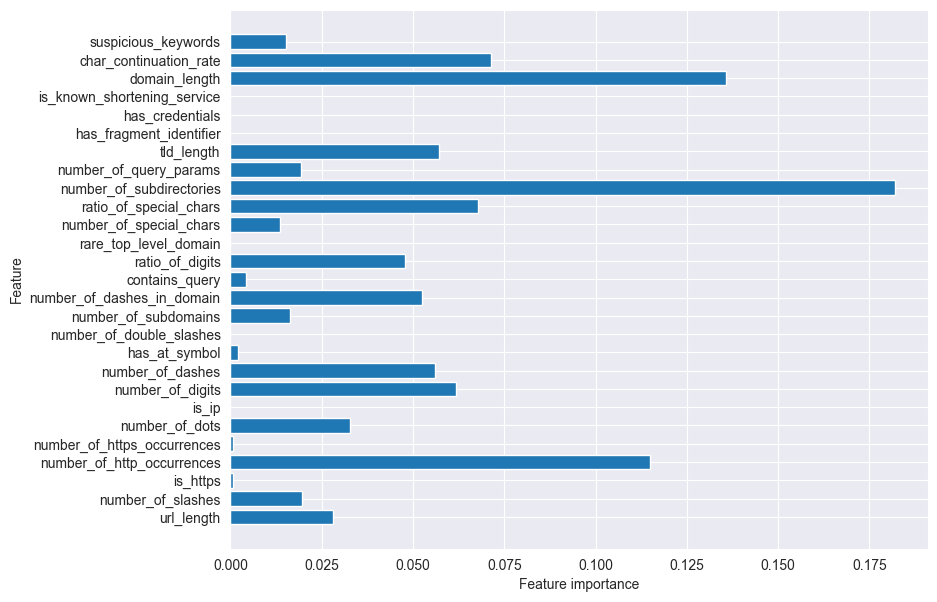

In [387]:
#checking the feature improtance in the model
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), best_tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

### XGBoost

In [413]:
param_dist = {
    "max_depth": randint(3, 11),
    "n_estimators": randint(1000, 2001),
    "learning_rate": loguniform(1e-2, 3e-1),
    "min_child_weight": loguniform(1e-1, 1e1),
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs = RandomizedSearchCV(XGBClassifier(random_state=42), param_dist, n_iter=36, cv=cv, scoring="f1",
                        n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)
best_xgb = rs.best_estimator_
rs.best_params_

{'learning_rate': np.float64(0.03574712922600244),
 'max_depth': 7,
 'min_child_weight': np.float64(0.23273922280628717),
 'n_estimators': 1071}

In [414]:
#predicting the target value from the model for the samples
y_test_xgb = rs.predict(X_test)
y_train_xgb = rs.predict(X_train)

In [419]:
#computing the accuracy of the model performance
acc_train_xgb = accuracy_score(y_train,y_train_xgb)
acc_test_xgb = accuracy_score(y_test,y_test_xgb)

print("XGBoost: Accuracy on training Data: {:.3f}".format(acc_train_xgb))
print("XGBoost : Accuracy on test Data: {:.3f}".format(acc_test_xgb))
print()

f1_score_train_xgb = metrics.f1_score(y_train,y_train_xgb)
f1_score_test_xgb = metrics.f1_score(y_test,y_test_xgb)
print("Decision Tree: f1_score on training Data: {:.3f}".format(f1_score_train_xgb))
print("Decision Tree: : f1_score on test Data: {:.3f}".format(f1_score_test_xgb))
print()

recall_score_train_xgb = metrics.recall_score(y_train,y_train_xgb)
recall_score_test_xgb = metrics.recall_score(y_test,y_test_xgb)
print("Decision Tree: : Recall on training Data: {:.3f}".format(recall_score_train_xgb))
print("Decision Tree: : Recall on test Data: {:.3f}".format(recall_score_test_xgb))
print()

precision_score_train_xgb = metrics.precision_score(y_train,y_train_xgb)
precision_score_test_xgb = metrics.precision_score(y_test,y_test_xgb)
print("Decision Tree: precision on training Data: {:.3f}".format(precision_score_train_xgb))
print("Decision Tree: precision on test Data: {:.3f}".format(precision_score_test_xgb))

XGBoost: Accuracy on training Data: 0.966
XGBoost : Accuracy on test Data: 0.911

Decision Tree: f1_score on training Data: 0.973
Decision Tree: : f1_score on test Data: 0.931

Decision Tree: : Recall on training Data: 0.982
Decision Tree: : Recall on test Data: 0.950

Decision Tree: precision on training Data: 0.964
Decision Tree: precision on test Data: 0.912


### Logistic Regression

In [431]:
pipe = Pipeline([("scaler", StandardScaler()),
                 ("lr", LogisticRegression(solver="saga", max_iter=10000, random_state=42))])

param_dist = {
    "lr__C": loguniform(1e-3, 1e-1),
    "lr__penalty": ["l1", "l2"],
}

rs = RandomizedSearchCV(pipe, param_dist, n_iter=36, cv=cv, scoring="f1", n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)
best_lr = rs.best_estimator_
rs.best_params_

{'lr__C': np.float64(0.07902619549708234), 'lr__penalty': 'l2'}

In [432]:
#predicting the target value from the model for the samples
y_test_lr = rs.predict(X_test)
y_train_lr = rs.predict(X_train)

In [435]:
#computing the accuracy of the model performance
acc_train_lr = accuracy_score(y_train,y_train_lr)
acc_test_lr = accuracy_score(y_test,y_test_lr)

print("Logistic Regression: Accuracy on training Data: {:.3f}".format(acc_train_lr))
print("Logistic Regression : Accuracy on test Data: {:.3f}".format(acc_test_lr))
print()

f1_score_train_lr = metrics.f1_score(y_train,y_train_lr)
f1_score_test_lr = metrics.f1_score(y_test,y_test_lr)
print("Decision Tree: f1_score on training Data: {:.3f}".format(f1_score_train_lr))
print("Decision Tree: : f1_score on test Data: {:.3f}".format(f1_score_test_lr))
print()

recall_score_train_lr = metrics.recall_score(y_train,y_train_lr)
recall_score_test_lr = metrics.recall_score(y_test,y_test_lr)
print("Decision Tree: : Recall on training Data: {:.3f}".format(recall_score_train_lr))
print("Decision Tree: : Recall on test Data: {:.3f}".format(recall_score_test_lr))
print()

precision_score_train_lr = metrics.precision_score(y_train,y_train_lr)
precision_score_test_lr = metrics.precision_score(y_test,y_test_lr)
print("Decision Tree: precision on training Data: {:.3f}".format(precision_score_train_lr))
print("Decision Tree: precision on test Data: {:.3f}".format(precision_score_test_lr))

Logistic Regression: Accuracy on training Data: 0.824
Logistic Regression : Accuracy on test Data: 0.823

Decision Tree: f1_score on training Data: 0.865
Decision Tree: : f1_score on test Data: 0.866

Decision Tree: : Recall on training Data: 0.897
Decision Tree: : Recall on test Data: 0.907

Decision Tree: precision on training Data: 0.836
Decision Tree: precision on test Data: 0.829


### K-Nearest-Neighbor

In [436]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_jobs=-1))
])

param_dist = {
    "knn__n_neighbors": np.arange(3, 65, 2),
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],                     # 1=Manhattan, 2=Euklidisch
    "knn__leaf_size": randint(15, 61),
    "knn__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=36,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    random_state=42
)

rs.fit(X_train, y_train)
best_knn = rs.best_estimator_
rs.best_params_

{'knn__algorithm': 'ball_tree',
 'knn__leaf_size': 17,
 'knn__n_neighbors': np.int64(3),
 'knn__p': 1,
 'knn__weights': 'distance'}

In [440]:
#predicting the target value from the model for the samples
y_test_knn = rs.predict(X_test)
y_train_knn = rs.predict(X_train)

In [441]:
#computing the accuracy of the model performance
acc_train_knn = accuracy_score(y_train,y_train_knn)
acc_test_knn = accuracy_score(y_test,y_test_knn)

print("Logistic Regression: Accuracy on training Data: {:.3f}".format(acc_train_knn))
print("Logistic Regression : Accuracy on test Data: {:.3f}".format(acc_test_knn))
print()

f1_score_train_knn = metrics.f1_score(y_train,y_train_knn)
f1_score_test_knn = metrics.f1_score(y_test,y_test_knn)
print("Decision Tree: f1_score on training Data: {:.3f}".format(f1_score_train_knn))
print("Decision Tree: : f1_score on test Data: {:.3f}".format(f1_score_test_knn))
print()

recall_score_train_knn = metrics.recall_score(y_train,y_train_knn)
recall_score_test_knn = metrics.recall_score(y_test,y_test_knn)
print("Decision Tree: : Recall on training Data: {:.3f}".format(recall_score_train_knn))
print("Decision Tree: : Recall on test Data: {:.3f}".format(recall_score_test_knn))
print()

precision_score_train_knn = metrics.precision_score(y_train,y_train_knn)
precision_score_test_knn = metrics.precision_score(y_test,y_test_knn)
print("Decision Tree: precision on training Data: {:.3f}".format(precision_score_train_knn))
print("Decision Tree: precision on test Data: {:.3f}".format(precision_score_test_knn))

Logistic Regression: Accuracy on training Data: 0.982
Logistic Regression : Accuracy on test Data: 0.906

Decision Tree: f1_score on training Data: 0.986
Decision Tree: : f1_score on test Data: 0.926

Decision Tree: : Recall on training Data: 0.984
Decision Tree: : Recall on test Data: 0.936

Decision Tree: precision on training Data: 0.988
Decision Tree: precision on test Data: 0.916


### Naive Bayes

In [449]:
nb = GaussianNB()

param_dist = {
    "var_smoothing": loguniform(1e-12, 1e-6),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    nb, param_distributions=param_dist, n_iter=36,
    cv=cv, scoring="f1", n_jobs=-1, random_state=42
)
rs.fit(X_train, y_train)
best_nb = rs.best_estimator_
rs.best_params_

{'var_smoothing': np.float64(7.085721663941593e-08)}

In [450]:
#predicting the target value from the model for the samples
y_test_nb = rs.predict(X_test)
y_train_nb = rs.predict(X_train)

In [451]:
#computing the accuracy of the model performance
acc_train_nb = accuracy_score(y_train,y_train_nb)
acc_test_nb = accuracy_score(y_test,y_test_nb)

print("Logistic Regression: Accuracy on training Data: {:.3f}".format(acc_train_nb))
print("Logistic Regression : Accuracy on test Data: {:.3f}".format(acc_test_nb))
print()

f1_score_train_nb = metrics.f1_score(y_train,y_train_nb)
f1_score_test_nb = metrics.f1_score(y_test,y_test_nb)
print("Decision Tree: f1_score on training Data: {:.3f}".format(f1_score_train_nb))
print("Decision Tree: : f1_score on test Data: {:.3f}".format(f1_score_test_nb))
print()

recall_score_train_nb = metrics.recall_score(y_train,y_train_nb)
recall_score_test_nb = metrics.recall_score(y_test,y_test_nb)
print("Decision Tree: : Recall on training Data: {:.3f}".format(recall_score_train_nb))
print("Decision Tree: : Recall on test Data: {:.3f}".format(recall_score_test_nb))
print()

precision_score_train_nb = metrics.precision_score(y_train,y_train_nb)
precision_score_test_nb = metrics.precision_score(y_test,y_test_nb)
print("Decision Tree: precision on training Data: {:.3f}".format(precision_score_train_nb))
print("Decision Tree: precision on test Data: {:.3f}".format(precision_score_test_nb))

Logistic Regression: Accuracy on training Data: 0.770
Logistic Regression : Accuracy on test Data: 0.776

Decision Tree: f1_score on training Data: 0.833
Decision Tree: : f1_score on test Data: 0.838

Decision Tree: : Recall on training Data: 0.914
Decision Tree: : Recall on test Data: 0.920

Decision Tree: precision on training Data: 0.766
Decision Tree: precision on test Data: 0.769


### Evaluation

In [81]:
data = pd.read_csv("features.csv")
data.head()

,url,label,url_length,number_of_slashes,is_https,number_of_http_occurrences,number_of_https_occurrences,number_of_dots,is_ip,number_of_digits,...,ratio_of_special_chars,number_of_subdirectories,number_of_query_params,tld_length,has_fragment_identifier,has_credentials,is_known_shortening_service,domain_length,char_continuation_rate,suspicious_keywords
0,https://github.com/vaibhavbichave/Phishing-URL...,1,97,7,0,0,1,2,1,0,...,0.144330,5,0,3,1,1,1,10,0.175258,1
1,https://chatgpt.com/c/69012792-5030-8321-99aa-...,1,58,4,0,0,1,1,1,25,...,0.172414,2,0,3,1,1,1,11,0.310345,1
2,https://calendar.google.com/calendar/u/0/r?pli=1,1,48,6,0,0,1,2,1,2,...,0.229167,4,1,3,1,1,1,19,0.250000,1
3,https://rbfcu-star.azurewebsites.net/(S(p43ff0...,0,67,4,0,0,1,2,1,6,...,0.179104,1,0,3,1,1,1,28,0.268657,1
4,https://appleallpay.github.io/,0,30,3,0,0,1,2,1,0,...,0.200000,0,0,2,1,1,1,21,0.466667,1


In [83]:
data.nunique()

url                            6
label                          2
url_length                     6
number_of_slashes              4
is_https                       2
number_of_http_occurrences     2
number_of_https_occurrences    2
number_of_dots                 2
is_ip                          1
number_of_digits               5
number_of_dashes               4
has_at_symbol                  1
number_of_double_slashes       1
number_of_subdomains           2
number_of_dashes_in_domain     3
contains_query                 2
ratio_of_digits                5
rare_top_level_domain          1
number_of_special_chars        6
ratio_of_special_chars         6
number_of_subdirectories       5
number_of_query_params         2
tld_length                     2
has_fragment_identifier        1
has_credentials                1
is_known_shortening_service    1
domain_length                  6
char_continuation_rate         6
suspicious_keywords            2
dtype: int64

In [84]:
data = data.drop(['url'], axis=1)

In [85]:
plt.show()
X = data.drop(['label'], axis=1)
y = data['label']

In [89]:
y_test_new = grid.predict(X)

In [90]:
acc_test_svc = metrics.accuracy_score(y,y_test_new)
print("Support Vector Machine : Accuracy on test Data: {:.3f}".format(acc_test_svc))
print()

f1_score_test_svc = metrics.f1_score(y,y_test_new)
print("Support Vector Machine : f1_score on test Data: {:.3f}".format(f1_score_test_svc))
print()

recall_score_test_svc = metrics.recall_score(y,y_test_new)
print("Support Vector Machine : Recall on test Data: {:.3f}".format(recall_score_test_svc))
print()

precision_score_test_svc = metrics.precision_score(y,y_test_new)
print("Support Vector Machine : precision on test Data: {:.3f}".format(precision_score_test_svc))

Support Vector Machine : Accuracy on test Data: 0.833

Support Vector Machine : f1_score on test Data: 0.857

Support Vector Machine : Recall on test Data: 1.000

Support Vector Machine : precision on test Data: 0.750


In [91]:
print(metrics.classification_report(y, y_test_new))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



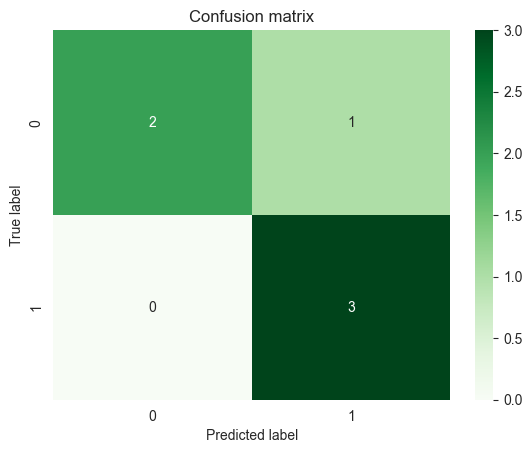

In [92]:
svm_conf_matrix = metrics.confusion_matrix(y,y_test_new)

sns.heatmap(svm_conf_matrix, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()